In [17]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from PIL import Image
import PIL.ImageOps

import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset, ConcatDataset
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import losses
import utils

In [2]:
print("Current CUDA Device #:", torch.cuda.current_device())
print("Number of CUDA Devices: ", torch.cuda.device_count())
print("CUDA Device name: ", torch.cuda.get_device_name(0))

Current CUDA Device #: 0
Number of CUDA Devices:  1
CUDA Device name:  Tesla K80


In [ ]:
%run utils.ipynb
%run models.ipynb

In [3]:
class palmFromText(Dataset): 
    def __init__(self, path, img_dir, transform=None):
        self.path = path
        self.transform = transform           
        self.img_file = open(img_dir, 'r')
        self.img_anno_list = []
        for line in self.img_file:
            self.img_anno_list.append(line[:-1])
            
    def __getitem__(self, index):
        img_name = str(self.img_anno_list[index] + ".jpg")
        mask_name = str(self.img_anno_list[index] + ".bmp")
        
        img = Image.open(os.path.join(self.path, "PALM-Training400", img_name))
        mask = Image.open(os.path.join(self.path, "Disc_Masks", mask_name ))
        mask = PIL.ImageOps.invert(mask)

        if self.transform is not None: 
            img = self.transform(img)
            mask = self.transform(mask)
            return img, mask

    def __len__(self):
        return len(self.img_anno_list)

In [4]:
root_dir = "dataset/"
img_list = os.listdir(os.path.join(root_dir, 'PALM-Training400'))
gt_list = os.listdir(os.path.join(root_dir, 'Disc_Masks'))
test_list = os.listdir(os.path.join(root_dir, 'Validation-400'))

batch_size = 2
val_split = 0.1
imsize = 256
num_train = len(img_list)
indices = np.arange(num_train)
split = int(np.floor(val_split*num_train))
train_idx, val_idx = indices[split:], indices[:split]

In [5]:
t = transforms.Compose([transforms.Resize((imsize, imsize)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0,0,0],
                                                           [1,1,1])])

train_data = palmFromText(root_dir, "train.txt", transform=t)
val_data = palmFromText(root_dir, "trainval.txt", transform=t)
#test_data = palmFromText(root_dir, np.array(test_list), transform=t)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

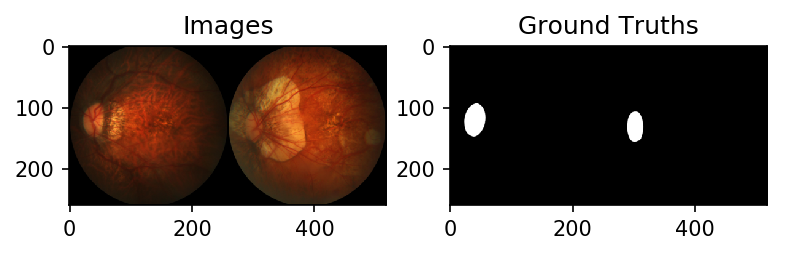

In [6]:
#visualize train datasets
X,Y = next(iter(train_loader))
plt.figure(dpi=150)
plt.subplot(121)
plt.title('Images')
grid_img = vutils.make_grid(X, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))
plt.subplot(122)
plt.title('Ground Truths')
gt_grid = vutils.make_grid(Y, nrow=4)
plt.imshow(gt_grid.permute(1,2,0))

In [7]:
def conv_relu_bn(in_channels, out_channels, kernel=3):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
            )
  
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.conv1 = conv_relu_bn(self.n_channels,64)
        self.conv2 = conv_relu_bn(64,128)
        self.conv3 = conv_relu_bn(128,256)
        self.conv4 = conv_relu_bn(256,512)
        self.conv5 = conv_relu_bn(512,512)
        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.up4 = conv_relu_bn(512 + 512, 512)
        self.up3 = conv_relu_bn(256 + 512, 256)
        self.up2 = conv_relu_bn(128 + 256, 128)
        self.up1 = conv_relu_bn(64 + 128, 64)
        
        self.output = nn.Sequential(nn.Conv2d(64, n_classes, 1),
                                    nn.Sigmoid())
        
    def forward(self, x):
        conv1 = self.conv1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.conv2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.conv3(x)
        x = self.maxpool(conv3)
        
        conv4 = self.conv4(x)
        x = self.maxpool(conv4)
       
        x = self.conv5(x)
        
        x = self.upsample(x)
        x = torch.cat([conv4, x], dim=1)
        x = self.up4(x)
        
        x = self.upsample(x)
        x = torch.cat([conv3, x], dim=1)
        x = self.up3(x)
        
        x = self.upsample(x)
        x = torch.cat([conv2, x], dim=1)
        x = self.up2(x)
        
        x = self.upsample(x)
        x = torch.cat([conv1, x], dim=1)
        x = self.up1(x)
        out = self.output(x)
        return out

In [8]:
def dice_score(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dsc = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    return dsc.mean()

def dice_loss(pred, target, smooth=1):
    dsc = dice_score(pred, target)
    return 1 - dsc
   
def tversky(y_true, y_pred, smooth=1., alpha=0.5):
    y_true_pos = y_true.contiguous()
    y_pred_pos = y_pred.contiguous()
    true_pos = (y_true_pos * y_pred_pos).sum().sum()
    false_neg = (y_true_pos * (1-y_pred_pos)).sum().sum()
    false_pos = (1-y_true_pos)*(y_pred_pos).sum().sum()
    
    return ((true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)).mean()

def tl(y_true, y_pred):
    return 1-tversky(y_true,y_pred, alpha=0.6)

def ftl(y_true, y_pred, gamma=0.75):
    x = 1-tversky(y_true, y_pred, alpha=0.6)
    return x**gamma

In [12]:
model = unet(n_channels=3, n_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
model = model.to(device)

In [13]:
epochs = 50
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)

In [14]:
print('='*30)
print('Training')
print('='*30)

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for e in range(epochs):
    train_loss = 0
    train_acc = 0
    steps = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        opt.zero_grad()
        preds = model(images)

        loss = dice_loss(preds, masks)
        
        loss.backward()
        opt.step()
        train_loss += loss.detach().item()
        train_acc += dice_score(preds, masks).detach().item()

    else:        
        val_loss = 0
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                preds = model.forward(inputs)
                batch_loss = dice_loss(preds, masks)
                
                val_loss += batch_loss.detach().item()
                val_acc += dice_score(preds, masks).detach().item()
                
        print("Epoch {}/{} \t Train loss:{:.5} \t Train Acc:{:.5} \t Val Loss:{:.5} \t Val Acc:{:.5}".format(
                e+1, epochs, 
                train_loss/len(train_loader), 
                train_acc/len(train_loader),
                val_loss/len(val_loader), 
                val_acc/len(val_loader)))
        torch.cuda.empty_cache()
        #train_loss_history.append(train_loss/len(train_loader))
        #val_loss_history.append(val_loss/len(train_loader))
        #train_acc_history.append(train_acc/len(train_loader))
        #val_acc_history.append(val_acc/len(train_loader))

        model.train()

Training


/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Epoch 1/50 	 Train loss:0.81795 	 Train Acc:0.18205 	 Val Loss:0.81358 	 Val Acc:0.18642
Epoch 2/50 	 Train loss:0.48655 	 Train Acc:0.51345 	 Val Loss:0.45002 	 Val Acc:0.54998
Epoch 3/50 	 Train loss:0.30608 	 Train Acc:0.69392 	 Val Loss:0.32544 	 Val Acc:0.67456
Epoch 4/50 	 Train loss:0.24537 	 Train Acc:0.75463 	 Val Loss:0.32627 	 Val Acc:0.67373
Epoch 5/50 	 Train loss:0.21443 	 Train Acc:0.78557 	 Val Loss:0.27739 	 Val Acc:0.72261
Epoch 6/50 	 Train loss:0.21392 	 Train Acc:0.78608 	 Val Loss:0.26047 	 Val Acc:0.73953
Epoch 7/50 	 Train loss:0.18705 	 Train Acc:0.81295 	 Val Loss:0.26148 	 Val Acc:0.73852
Epoch 8/50 	 Train loss:0.18447 	 Train Acc:0.81553 	 Val Loss:0.23116 	 Val Acc:0.76884
Epoch 9/50 	 Train loss:0.16825 	 Train Acc:0.83175 	 Val Loss:0.23517 	 Val Acc:0.76483
Epoch 10/50 	 Train loss:0.2036 	 Train Acc:0.7964 	 Val Loss:0.25642 	 Val Acc:0.74358
Epoch 11/50 	 Train loss:0.22544 	 Train Acc:0.77456 	 Val Loss:0.3157 	 Val Acc:0.6843
Epoch 12/50 	 Train los

In [15]:
torch.save(model, "model-82.3.pth")

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [27]:
# check model outputs on validation data
model.eval()
idx = np.random.randint(0,batch_size)

val_dsc = []
with torch.no_grad():
    for x_val, y_val in val_loader:
        x_val, y_val = x_val.to(device), y_val.to(device)
        preds = model(x_val)
        dsc = losses.dice_score(preds, y_val)
        dsc = dsc.cpu().detach().numpy()
        val_dsc.append(dsc/x_val.shape[0])

/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Average DSC score = 0.41177225708961485


Text(0.5,1,'gt')

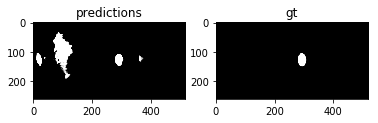

In [28]:

print('='*50)
print('Average DSC score =', np.array(val_dsc).mean())

preds = preds.cpu().detach()
y_val = y_val.cpu().detach()

grid_img = vutils.make_grid(y_val)
grid_pred = vutils.make_grid(preds)
plt.subplot(121)
plt.imshow(grid_pred.permute(1,2,0))
plt.title("predictions")

plt.subplot(122)
plt.imshow(grid_img.permute(1,2,0))
plt.title("gt")